# Transfer Learning

Neste exemplo, usaremos os pesos da ***ResNet50***, pré-treinados no conjunto ImageNet, para classificação das imagens do CIFAR-10. A ideia é que os filtros da rede aprendidos durante o pré-treinamento com o conjunto ImageNet auxiliem na tarefa de classificação do CIFAR-10, por mais que as distribuições dos dados sejam diferentes.

Para verificarmos isso, faremos dois experimentos:

1. Usaremos a rede como um extrator de características, descartando a última camada e congelando as camadas restantes. Em seguida, adicionaremos uma nova camada de saída com o número de classes do CIFAR-10, ajustando a rede para o novo conjunto de dados.

2. Após este primeiro treinamento, vamos descongelar as camadas e treiná-las ajustando os pesos do modelo para o conjunto CIFAR-10. Esse processo nós chamamos de _fine-tuning_.

In [1]:
!pip3 install --upgrade tensorflow==2.15 &> /dev/null

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score

#Utility to plot
def plotImages(imgList, n_row=1, n_col=1):
    _, axs = plt.subplots(n_row, n_col, figsize=(5, 5))
    axs = axs.flatten()
    for img, ax in zip(imgList, axs):
        ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()


def plotImage(img):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()

## CIFAR-10

Conjunto de dados composto de 60.000 imagens coloridas de dimensões 32x32, divididas em 10 classes (com 6.000 imagens por classe), sendo 50.000 para treinamento e 10.000 para teste. As classes do CIFAR-10 são **aviões, automóveis, pássaros, gatos, alces, cachorros, sapos, cavalos, navios, caminhões.**


O código abaixo carrega e transforma os dados de entrada para ficarem prontos para serem treinados/classificados pela sua rede. Os conjuntos de treino, validação e teste estão balanceados, portanto a acurácia já estará normalizada nos métodos do Keras.

***Veja como pré-processamos os dados com a função do próprio modelo pré-treinado.***

In [3]:
# Carrega o dataset
(trainVal_data, trainVal_label), (X_test, y_test) = cifar10.load_data()

#Split trainVal data into train and val sets (already balanced)
sss = StratifiedShuffleSplit(1, test_size=10000, random_state=0)
for train_index, val_index in sss.split(trainVal_data, trainVal_label):
    X_train, X_val = trainVal_data[train_index], trainVal_data[val_index]
    y_train, y_val = trainVal_label[train_index], trainVal_label[val_index]

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

print("Dados de treino:", X_train.shape)
print("Dados de validação:", X_val.shape)
print("Dados de teste:", X_test.shape)
print()
n_classes = 10

# One-hot encoding
Y_train = tf.keras.utils.to_categorical(y_train, n_classes)
Y_val = tf.keras.utils.to_categorical(y_val, n_classes)
Y_test = tf.keras.utils.to_categorical(y_test, n_classes)

# Computa a distribuição de amostras por classe
num_train_classes, _ = np.histogram(y_train, bins=np.arange(n_classes)+1)
num_valid_classes, _ = np.histogram(y_val, bins=np.arange(n_classes)+1)
num_test_classes, _ = np.histogram(y_test, bins=np.arange(n_classes)+1)

print("Distribuição de amostras por classe:")
print(" - treino:", num_train_classes)
print(" - validação:", num_valid_classes)
print(" - teste:", num_test_classes)

170498071/170498071 [==============================] - 6s 0us/step
Dados de treino: (40000, 32, 32, 3)
Dados de validação: (10000, 32, 32, 3)
Dados de teste: (10000, 32, 32, 3)

Distribuição de amostras por classe:
 - treino: [4000 4000 4000 4000 4000 4000 4000 4000 4000]
 - validação: [1000 1000 1000 1000 1000 1000 1000 1000 1000]
 - teste: [1000 1000 1000 1000 1000 1000 1000 1000 1000]


(64, 32, 32, 3) (64, 10)
(64, 32, 32, 3) (64, 10)
imagens apenas com aumentações


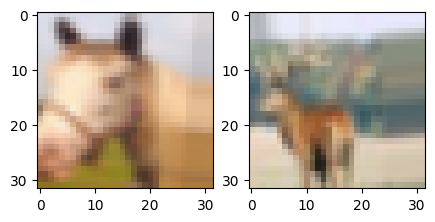

imagens com aumentações + pré-processamento resnet


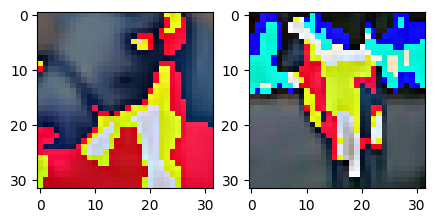

In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen_for_printing = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen_resnet = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=[0.6, 1],
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
    )

# datagen com preprocessing
gerador_batches_printing = datagen_for_printing.flow(X_train, Y_train, shuffle=False, batch_size=64)
batch_X, batch_Y = next(gerador_batches_printing)

gerador_batches_resnet = datagen_resnet.flow(X_train, Y_train, shuffle=False, batch_size=64)
batch_X_proc, batch_Y_proc = next(gerador_batches_resnet)

print(batch_X.shape, batch_Y.shape)
print(batch_X_proc.shape, batch_Y_proc.shape)

print("imagens apenas com aumentações")
plotImages(batch_X[:2], 1, 2)

print("imagens com aumentações + pré-processamento resnet")
plotImages(batch_X_proc[:2], 1, 2)


## Usando a rede como um extrator de features

### Congelamento das camadas

Vamos pegar a saída da ResNet50 após todas as convoluções, remover a última camada (``include_top=false``), congelar os pesos restantes, e adicionar uma camada densa treinável para as novas classes do CIFAR-10. Assim, podemos pensar nas camadas congeladas como extrator de características.

Note que neste experimento nós apenas treinamos as últimas camadas adicionadas, deixando fixos os pesos das outras camadas. Fazemos isso justamente para podermos ajustar as features extraídas pela rede para o conjunto CIFAR-10. Em seguida, tendo essas features já ajustadas para o conjunto alvo, podemos treinar um classificador qualquer (um SVM, por exemplo). Essa técnica é bastante útil em cenários de escassez de dados ou de pouco poder computacional.


In [5]:
# Carregamento do modelo pré-treinado SEM a última camada densa (include_top = False)
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))
model.summary()

# Congela camadas pré-treinadas
for layer in model.layers:
    layer.trainable = False

# Insere novas camadas no fim da rede para classificação
frozen_model = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10, activation='softmax')
])

frozen_model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                      

Vamos compilar e treinar o modelo

In [6]:
# Instancia um otimizador SGD, compila e treina o modelo completo
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, weight_decay=0.001)

# Batches de treino e validação
train_batches = datagen_resnet.flow(X_train, Y_train, shuffle=True, batch_size=64)
val_batches = datagen_resnet.flow(X_val, Y_val, shuffle=False, batch_size=64)

# Early Stopping
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

frozen_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

frozen_model.fit(train_batches,
                 epochs=25,
                 callbacks=[early],
                 validation_data=val_batches)

Epoch 1/25
625/625 [==============================] - 54s 76ms/step - loss: 2.0381 - accuracy: 0.4836 - val_loss: 1.8066 - val_accuracy: 0.5169
Epoch 2/25
625/625 [==============================] - 40s 65ms/step - loss: 1.6605 - accuracy: 0.5378 - val_loss: 1.6604 - val_accuracy: 0.5381
Epoch 3/25
625/625 [==============================] - 43s 69ms/step - loss: 1.6291 - accuracy: 0.5418 - val_loss: 1.6029 - val_accuracy: 0.5469
Epoch 4/25
625/625 [==============================] - 40s 64ms/step - loss: 1.5644 - accuracy: 0.5549 - val_loss: 1.5264 - val_accuracy: 0.5423
Epoch 5/25
625/625 [==============================] - 38s 62ms/step - loss: 1.5359 - accuracy: 0.5582 - val_loss: 1.5586 - val_accuracy: 0.5483
Epoch 6/25
625/625 [==============================] - 38s 61ms/step - loss: 1.5382 - accuracy: 0.5580 - val_loss: 1.5386 - val_accuracy: 0.5632
Epoch 7/25
625/625 [==============================] - 38s 62ms/step - loss: 1.5406 - accuracy: 0.5598 - val_loss: 1.6236 - val_accuracy:

In [7]:
# Avalia o modelo na validação
score = frozen_model.evaluate(val_batches,verbose=1)

print('Valid loss:', score[0])
print('Valid acc:', score[1])

157/157 [==============================] - 8s 51ms/step - loss: 1.4952 - accuracy: 0.5628
Valid loss: 1.4952123165130615
Valid acc: 0.5627999901771545


### Treinando um classificador a partir das features extraídas pela rede

Uma alternativa ao exemplo anterior, ainda seguinda a ideia de usar a rede como extrator de características, seria treinar um SVM ou uma MLP a partir das features extraídas pelo modelo.

In [8]:
# Carrega o modelo base novamente
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))

# Congela todas as camadas colocando o parametro treinable como false
for layer in model.layers:
    layer.trainable = False

frozen_model = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D()
])

feats_train = frozen_model.predict(X_train)
feats_val = frozen_model.predict(X_val)

313/313 [==============================] - 3s 7ms/step


In [9]:
print(feats_train.shape)

from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300).fit(feats_train, Y_train)

(40000, 2048)


In [10]:
acc_mlp = clf.score(feats_val, Y_val)
print("ACC MLP:", acc_mlp)

ACC MLP: 0.4586


## Fine-tuning

Vamos agora descongelar o modelo inteiro e realizar o _fine-tuning_ da rede para o CIFAR-10.

In [11]:
# Carrega o modelo base novamente
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))

# descongelando os pesos da rede
for layer in model.layers:
    layer.trainable = True

ft_model = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10, activation='softmax')
])

ft_model.summary() #Note o núúmero de paramêtros treináveis

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23608202 (90.06 MB)
Trainable params: 23555082 (89.86 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [12]:
# Compila e treina o modelo
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, weight_decay=0.001)

# Batches de treino e validação
train_batches = datagen_resnet.flow(X_train, Y_train, shuffle=True, batch_size=64)
val_batches = datagen_resnet.flow(X_val, Y_val, shuffle=False, batch_size=64)

ft_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
ft_model.fit(train_batches, epochs=25, validation_data=val_batches)

Epoch 1/25
625/625 [==============================] - 76s 87ms/step - loss: 1.5786 - accuracy: 0.4908 - val_loss: 1.4334 - val_accuracy: 0.5535
Epoch 2/25
625/625 [==============================] - 56s 89ms/step - loss: 1.1104 - accuracy: 0.6241 - val_loss: 1.0713 - val_accuracy: 0.6496
Epoch 3/25
625/625 [==============================] - 54s 87ms/step - loss: 0.9863 - accuracy: 0.6697 - val_loss: 0.9422 - val_accuracy: 0.6773
Epoch 4/25
625/625 [==============================] - 55s 88ms/step - loss: 0.9146 - accuracy: 0.6927 - val_loss: 0.8842 - val_accuracy: 0.7047
Epoch 5/25
625/625 [==============================] - 53s 86ms/step - loss: 0.8416 - accuracy: 0.7117 - val_loss: 0.8283 - val_accuracy: 0.7157
Epoch 6/25
625/625 [==============================] - 53s 85ms/step - loss: 0.7797 - accuracy: 0.7317 - val_loss: 0.7874 - val_accuracy: 0.7274
Epoch 7/25
625/625 [==============================] - 56s 89ms/step - loss: 0.7424 - accuracy: 0.7434 - val_loss: 0.8234 - val_accuracy:

In [13]:
score = ft_model.evaluate(val_batches,verbose=1)
print('Val loss:', score[0])
print('Val acc:', score[1])

157/157 [==============================] - 8s 51ms/step - loss: 0.6001 - accuracy: 0.7978
Val loss: 0.6000809073448181
Val acc: 0.7978000044822693


### Resultados em validação

| Modelo | Acurácia (%) |
|--------|--------------|
| modelo  congelado + MLP | 45.68 |
| modelo  congelado + FC  | 56.98 |
| modelo  descongelado (finetuning)  | 78.93 |

### Avaliando o modelo no conjunto de teste

Finalmente, após todos os nossos experimentos, avaliaremos o modelo final no conjunto de teste.

In [14]:
test_batches = datagen_resnet.flow(X_test, Y_test, shuffle=False, batch_size=64)

score_test = ft_model.evaluate(test_batches,verbose=1)
print('Test loss:', score_test[0])
print('Test acc:', score_test[1])

157/157 [==============================] - 9s 59ms/step - loss: 0.5958 - accuracy: 0.7990
Test loss: 0.5957561731338501
Test acc: 0.7990000247955322
